In [3]:
import pandas as pd
import numpy as np

from PyPDF2 import PdfReader

import re

from sentence_transformers import SentenceTransformer
# from sentence_transformers.evaluation import LabelAccuracyEvaluator

import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.express as px

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score

# from transformers import MarianMTModel, MarianTokenizer

# import torch
# from torch.utils.data import DataLoader

c:\Users\poletkina\AppData\Local\Programs\Python\Python38\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


# Data Frame from PDF

Link to PDF document -> https://www.sib.sachsen.de/download/RL/RL_Bau_Sachsen_Raumnutzungskatalog_NC-Katalog_Muster_13.pdf

In [16]:
# Load the PDF to extract text
pdf_path = './data/RL_Bau_Sachsen_Raumnutzungskatalog_NC-Katalog_Muster_13.pdf'
reader = PdfReader(pdf_path)

# Extract text from all pages and organize it
text_data = []
for page in reader.pages:
    text_data.append(page.extract_text())

# Combine all the pages into one text string
full_text = "\n".join(text_data)

# Displaying the start of the extracted text to understand its structure
print(full_text[:1000])

Katalog Nutzungscodes Version 2.2 vom 10.11.2017
Stand: DIN 277:2016-1RBK Neubau
NC Bezeichnung
1 Wohnen und Aufenthalt
11 Wohnräume
111 Wohnräume
11111 Wohnraum/ Schlafraum
11112 Wohnraum/ Schlafraum mit RLT 1
11121 Küche in Wohnung
11122 Küche in Wohnung mit RLT 1
11131 Diele
11132 Diele mit RLT 1
112 Internate, Wohnheime, Beherbergungsstätten
11211 Ein-/Zweibettzimmer
11212 Ein-/Zweibettzimmer mit Waschtisch
11213 Ein-/Zweibettzimmer mit RLT 1
11214 Ein-/Zweibettzimmer mit Waschtisch und RLT 1
11221 Mehrbettwohn-/ schlafraum
11222 Mehrbettwohn-/ schlafraum mit RLT 1
12 Gemeinschaftsräume
121 Aufenthaltsräume
12111 Aufenthaltsraum
12112 Aufenthaltsraum mit RLT 1
12113 Aufenthaltsraum Raumklasse II (OP-Bereich)
12121 Aufenthaltsraum mit Teeküche
12122 Aufenthaltsraum mit Teeküche und  RLT 1
12123 Aufenthaltsraum mit Teeküche und  RLT 3
122 Bereitschaftsräume
12211 Bereitschaftsraum
12212 Bereitschaftsraum mit Waschtisch
12213 Bereitschaftsraum mit RLT 1
Vermögen und Bau Baden-Württemb

In [7]:
# Initialize a data dictionary
data = {"NC": [], "Bezeichnung": []}

# Use regular expressions to capture lines with NC and descriptions
pattern = re.compile(r"^(\d{3,5})\s+(.+)$", re.MULTILINE)

Regular expressions  -> https://docs.python.org/3/library/re.html

In [8]:
matches = pattern.findall(full_text)
for nc, bezeichnung in matches:
    data["NC"].append(nc.strip())
    data["Bezeichnung"].append(bezeichnung.strip())

# Convert the extracted data into a DataFrame
df = pd.DataFrame(data)
df.head()

,NC,Bezeichnung
0,111,Wohnräume
1,11111,Wohnraum/ Schlafraum
2,11112,Wohnraum/ Schlafraum mit RLT 1
3,11121,Küche in Wohnung
4,11122,Küche in Wohnung mit RLT 1


In [9]:
# Apply class to name (Bezeichnung)
df['NUF'] = df['NC'].apply(lambda x: 'NUF_'+ x[0])
df['Bezeichnung'] = df['Bezeichnung'].apply(lambda x: x.lower())
df.head()

,NC,Bezeichnung,NUF
0,111,wohnräume,NUF_1
1,11111,wohnraum/ schlafraum,NUF_1
2,11112,wohnraum/ schlafraum mit rlt 1,NUF_1
3,11121,küche in wohnung,NUF_1
4,11122,küche in wohnung mit rlt 1,NUF_1


In [10]:
# Create new column with no spesial characters
df['bezeichnung_no_special_ch'] = df['Bezeichnung'].apply(
    lambda x: re.sub(r'ü', 'u', re.sub(r'ö', 'o', re.sub(r'ä', 'a', re.sub(r'ß', 'ss', x)))))
df.head()

,NC,Bezeichnung,NUF,bezeichnung_no_special_ch
0,111,wohnräume,NUF_1,wohnraume
1,11111,wohnraum/ schlafraum,NUF_1,wohnraum/ schlafraum
2,11112,wohnraum/ schlafraum mit rlt 1,NUF_1,wohnraum/ schlafraum mit rlt 1
3,11121,küche in wohnung,NUF_1,kuche in wohnung
4,11122,küche in wohnung mit rlt 1,NUF_1,kuche in wohnung mit rlt 1


In [11]:
# Create a new column with concatenated German + English text
df['concat_text'] = df.apply(lambda row: row['Bezeichnung'] + " | " + row['bezeichnung_no_special_ch'], axis=1)

In [12]:
df.head()

,NC,Bezeichnung,NUF,bezeichnung_no_special_ch,concat_text
0,111,wohnräume,NUF_1,wohnraume,wohnräume | wohnraume
1,11111,wohnraum/ schlafraum,NUF_1,wohnraum/ schlafraum,wohnraum/ schlafraum | wohnraum/ schlafraum
2,11112,wohnraum/ schlafraum mit rlt 1,NUF_1,wohnraum/ schlafraum mit rlt 1,wohnraum/ schlafraum mit rlt 1 | wohnraum/ sch...
3,11121,küche in wohnung,NUF_1,kuche in wohnung,küche in wohnung | kuche in wohnung
4,11122,küche in wohnung mit rlt 1,NUF_1,kuche in wohnung mit rlt 1,küche in wohnung mit rlt 1 | kuche in wohnung ...


In [13]:
# Check df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   NC                         1029 non-null   object
 1   Bezeichnung                1029 non-null   object
 2   NUF                        1029 non-null   object
 3   bezeichnung_no_special_ch  1029 non-null   object
 4   concat_text                1029 non-null   object
dtypes: object(5)
memory usage: 40.3+ KB


In [14]:
# Check the number of names in each class
df['NUF'].value_counts().sort_index()

NUF
NUF_1     79
NUF_2     76
NUF_3    194
NUF_4     96
NUF_5    108
NUF_6    179
NUF_7    186
NUF_8     60
NUF_9     51
Name: count, dtype: int64

In [17]:
#  Save df to csv
df.to_csv('./data/NUF_data.csv', index=False)

# Embeddings

About the model -> https://huggingface.co/sentence-transformers/paraphrase-multilingual-mpnet-base-v2

In [18]:
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

c:\Users\poletkina\AppData\Local\Programs\Python\Python38\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\poletkina\.cache\huggingface\hub\models--sentence-transformers--paraphrase-multilingual-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [19]:
# Create embeddings
# For clarity we add embedings to our table
df['embeddings_pmmb'] = model.encode(df['concat_text'].tolist(), convert_to_numpy=True).tolist()

df.head()

,NC,Bezeichnung,NUF,bezeichnung_no_special_ch,concat_text,embeddings_pmmb
0,111,wohnräume,NUF_1,wohnraume,wohnräume | wohnraume,"[-0.006622070446610451, -0.00950746051967144, ..."
1,11111,wohnraum/ schlafraum,NUF_1,wohnraum/ schlafraum,wohnraum/ schlafraum | wohnraum/ schlafraum,"[0.09401042014360428, -0.10377257317304611, -0..."
2,11112,wohnraum/ schlafraum mit rlt 1,NUF_1,wohnraum/ schlafraum mit rlt 1,wohnraum/ schlafraum mit rlt 1 | wohnraum/ sch...,"[0.05033388361334801, -0.17049270868301392, -0..."
3,11121,küche in wohnung,NUF_1,kuche in wohnung,küche in wohnung | kuche in wohnung,"[0.05317750573158264, -0.1698070764541626, -0...."
4,11122,küche in wohnung mit rlt 1,NUF_1,kuche in wohnung mit rlt 1,küche in wohnung mit rlt 1 | kuche in wohnung ...,"[0.0035692446399480104, -0.2456386536359787, -..."


In [20]:
embeddings_array = np.array(df['embeddings_pmmb'].tolist())

## Visualise the embeddings and check the separability

About `TSNE` -> https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [21]:
# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
reduced_embeddings = tsne.fit_transform(embeddings_array)
df['TSNE_1'] = reduced_embeddings[:, 0]
df['TSNE_2'] = reduced_embeddings[:, 1]

In [22]:
# Check how reduced dimentionality looks like
df.head()

,NC,Bezeichnung,NUF,bezeichnung_no_special_ch,concat_text,embeddings_pmmb,TSNE_1,TSNE_2
0,111,wohnräume,NUF_1,wohnraume,wohnräume | wohnraume,"[-0.006622070446610451, -0.00950746051967144, ...",-28.184807,10.141879
1,11111,wohnraum/ schlafraum,NUF_1,wohnraum/ schlafraum,wohnraum/ schlafraum | wohnraum/ schlafraum,"[0.09401042014360428, -0.10377257317304611, -0...",-26.322905,9.598689
2,11112,wohnraum/ schlafraum mit rlt 1,NUF_1,wohnraum/ schlafraum mit rlt 1,wohnraum/ schlafraum mit rlt 1 | wohnraum/ sch...,"[0.05033388361334801, -0.17049270868301392, -0...",37.124466,7.822794
3,11121,küche in wohnung,NUF_1,kuche in wohnung,küche in wohnung | kuche in wohnung,"[0.05317750573158264, -0.1698070764541626, -0....",-29.368334,53.656906
4,11122,küche in wohnung mit rlt 1,NUF_1,kuche in wohnung mit rlt 1,küche in wohnung mit rlt 1 | kuche in wohnung ...,"[0.0035692446399480104, -0.2456386536359787, -...",21.627090,36.956863


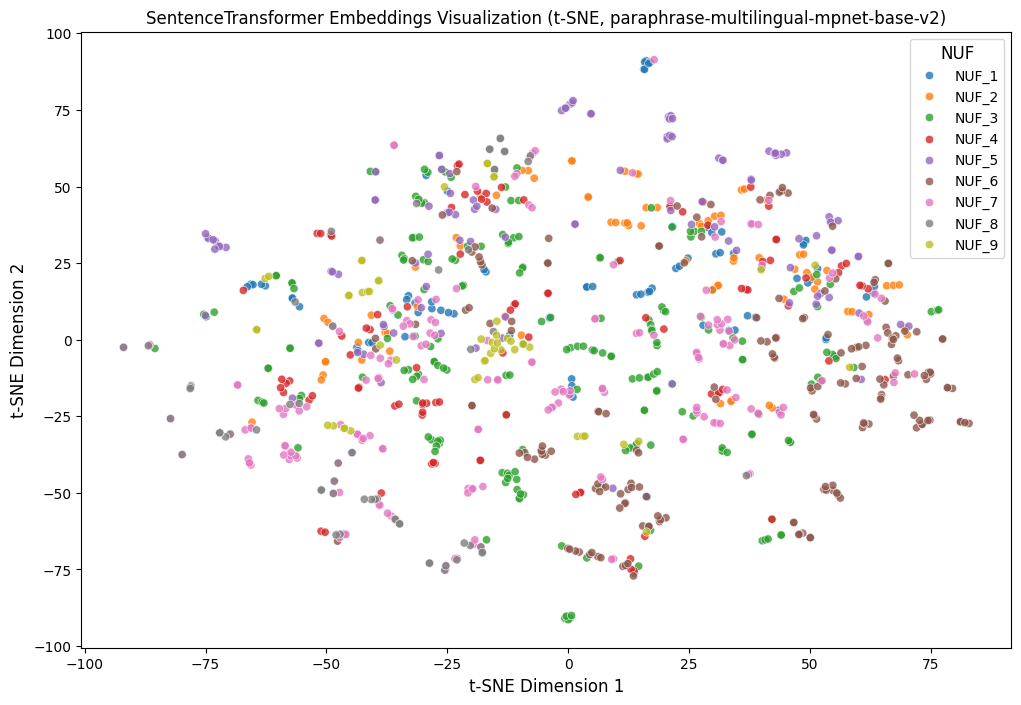

In [ ]:
# Plot the data with reduced dimentionality
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=df,
    x='TSNE_1',
    y='TSNE_2',
    hue='NUF',
    palette='tab10', 
    alpha=0.8 
)

plt.title("SentenceTransformer Embeddings Visualization (t-SNE, paraphrase-multilingual-mpnet-base-v2)", fontsize=12)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)
plt.legend(title='NUF', title_fontsize=12, fontsize=10) 

plt.show()

About `silhouette_score` -> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

In [30]:
silhouette = silhouette_score(embeddings_array, df['NUF'])
print(f"Silhouette Score: {silhouette}")

# Clusters are overlapping, or the data points assigned to a cluster are closer to points in other clusters than to points in their own cluster.

Silhouette Score: -0.023286364279385127


About `cosine_similarity` -> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html

In [31]:
# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(embeddings_array)
df_similarity = pd.DataFrame(similarity_matrix, index=df['NUF'], columns=df['NUF'])

# Compute average similarity within the same NUF and between different NUFs
unique_labels = df['NUF'].unique()
intra_similarity = {}
inter_similarity = []

for label in unique_labels:
    idx = df['NUF'] == label
    intra_similarity[label] = similarity_matrix[idx][:, idx].mean()

    # Get similarity with other NUFs
    inter_similarity.extend(similarity_matrix[idx][:, ~idx].flatten())

# Calculate overall inter-cluster similarity
inter_similarity_mean = np.mean(inter_similarity)

print("Intra-cluster cosine similarities:")
for label, sim in intra_similarity.items():
    print(f"{label}: {sim:.4f}")

Intra-cluster cosine similarities:
NUF_1: 0.6116
NUF_2: 0.6037
NUF_3: 0.5278
NUF_4: 0.5763
NUF_5: 0.5891
NUF_6: 0.5201
NUF_7: 0.5574
NUF_8: 0.5954
NUF_9: 0.5882
